In [1]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
import skimage

In [2]:
import sys
sys.path.append("../")
sys.path.append("../imagen/")

from helpers import *
from imagen_pytorch import Unet, Imagen, ImagenTrainer, NullUnet

/vol/bitbucket/pn222/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed_value = 42
torch.manual_seed(seed_value)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed_value)

In [4]:
RUN_NAME = "64_128_rot904_sep_3e-4"
BASE_DIR = f"/vol/bitbucket/pn222/models/{RUN_NAME}"

best_epoch_dict = {
    "64_128_1e-5": 45,
    "64_128_1e-4": 240,
    "64_128_3e-4": 220,    
    "64_128_1k_3e-4": 255,
    "64_128_rot904_3e-4": 85,
    "64_128_sep_3e-4": 220,
    "64_128_rot904_sep_3e-4": 135
}

In [5]:
unet1 = NullUnet()  

unet2 = Unet(
    dim = 32,
    cond_dim = 1024,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)
unets = [unet1, unet2]

class DDPMArgs:
    def __init__(self):
        pass
    
args = DDPMArgs()
args.batch_size = 16
args.image_size = 64 ; args.o_size = 64 ; args.n_size = 128 ;
args.continuous_embed_dim = 128*128*3
args.dataset_path = f"/vol/bitbucket/pn222/satellite/dataloader/{args.o_size}_{args.n_size}"
args.datalimit = False
args.lr = 3e-4

train_dataloader, test_dataloader = get_satellite_data(args)
_ = len(train_dataloader) ; _ = len(test_dataloader)

if '1k' in RUN_NAME:
    timesteps = 1000
else:
    timesteps = 250

imagen = Imagen(
    unets = unets,
    image_sizes = (64, 128),
    timesteps = timesteps,
    cond_drop_prob = 0.1,
    condition_on_continuous = True,
    continuous_embed_dim = args.continuous_embed_dim,
)

best_epoch = best_epoch_dict[RUN_NAME]
ckpt_trainer_path = f"{BASE_DIR}/models/64_128/ckpt_trainer_2_{best_epoch:03}.pt"
trainer = ImagenTrainer(imagen, lr=args.lr, verbose=False).cuda()
trainer.load(ckpt_trainer_path)  

def get_images(dataloader, random_idx):
    batch_idx = dataloader.random_idx[random_idx[0]]
    img_64, img_128, era5 = dataloader.get_batch(batch_idx)
    era5 = era5.reshape(era5.shape[0], -1)
    ema_sampled_images = imagen.sample(
        batch_size = img_64.shape[0],
        start_at_unet_number = 2,              
        start_image_or_video = img_64.float().cuda(),
        cond_scale = 3.,
        continuous_embeds=era5.float().cuda()
    )
    
    y_true = img_128.cpu()
    y_pred = ema_sampled_images.cpu()

    return y_true, y_pred

100%|███████████████████████████████████████████| 51/51 [00:58<00:00,  1.15s/it]


In [6]:
def get_bilinear_interpolation(img_64, idx, n_size=128):
    im64_2x = skimage.transform.resize(img_64[idx][0], (n_size, n_size), anti_aliasing=True)
    return im64_2x

def show_imgs(img_bi, img_gen, img_true, mode):
    fig, axs = plt.subplots(1, 3, figsize=(10, 12))
    axs[0].imshow(img_bi, cmap="gray")   ; axs[0].set_title(f"{mode} | Bi-Linear ")
    axs[1].imshow(img_gen, cmap="gray")  ; axs[1].set_title(f"{mode} | Diffusion SR")
    axs[2].imshow(img_true, cmap="gray") ; axs[2].set_title(f"{mode} | Actual")
    for ax in axs: 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
    fig.subplots_adjust(wspace=0.1, hspace=0)    
    plt.show()

Sampling: 100%|███████████████████████████████| 250/250 [00:37<00:00,  6.72it/s]
2it [00:37, 18.70s/it]


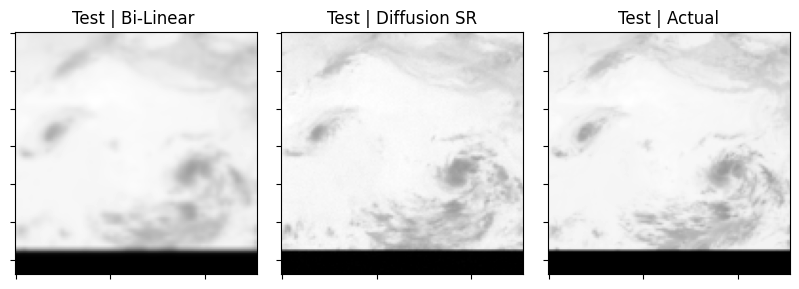

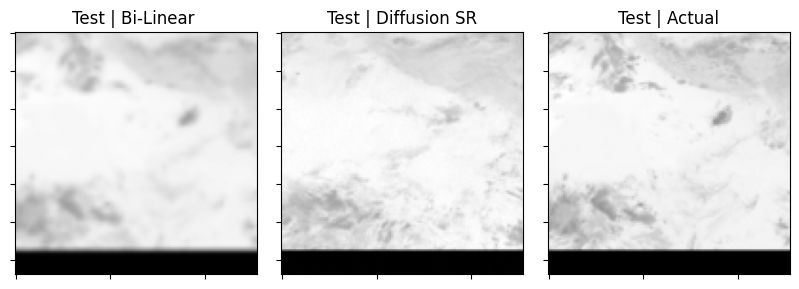

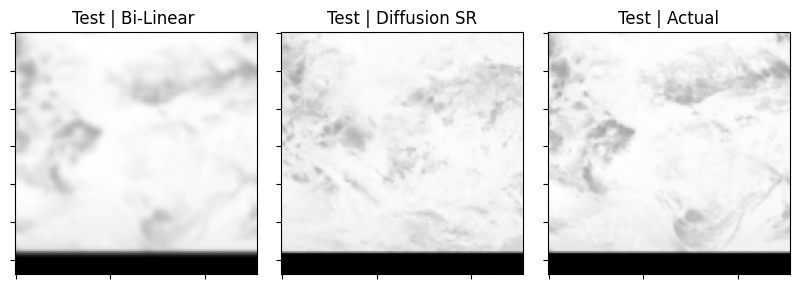

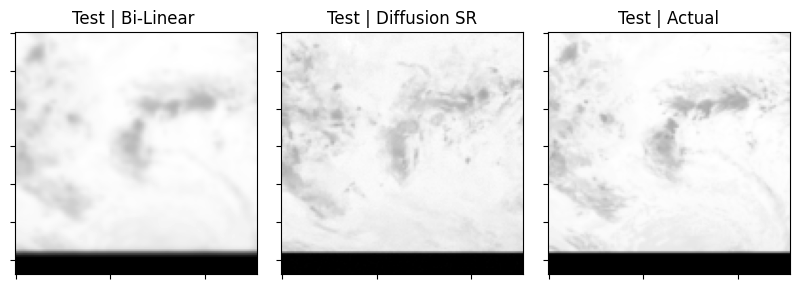

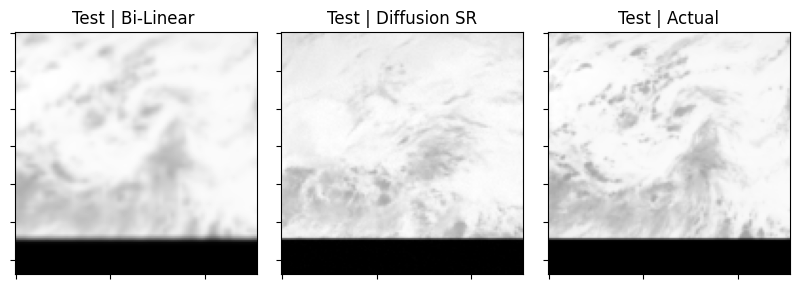

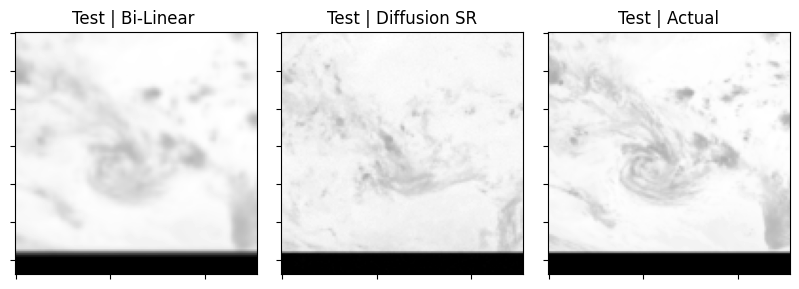

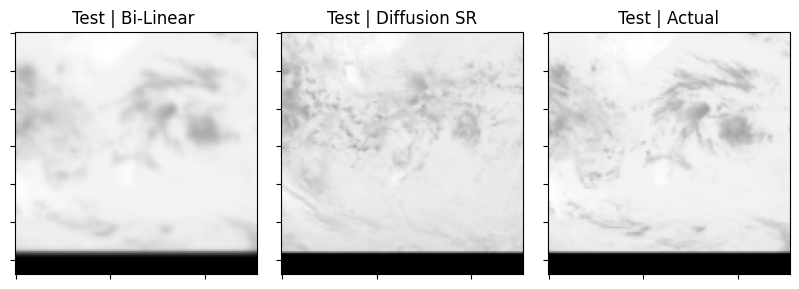

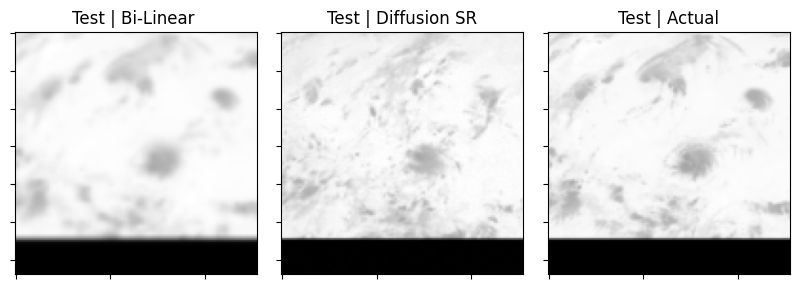

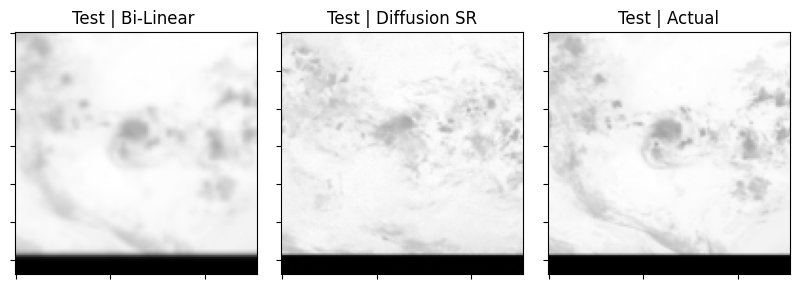

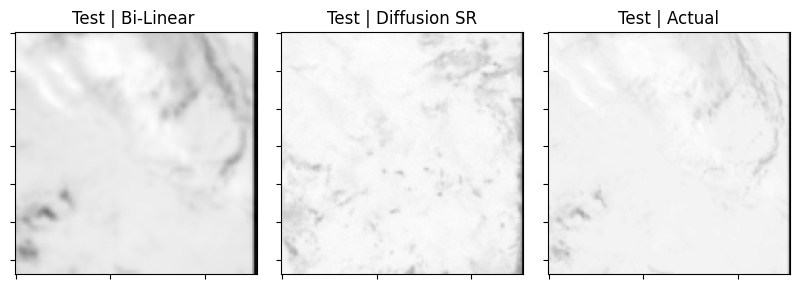

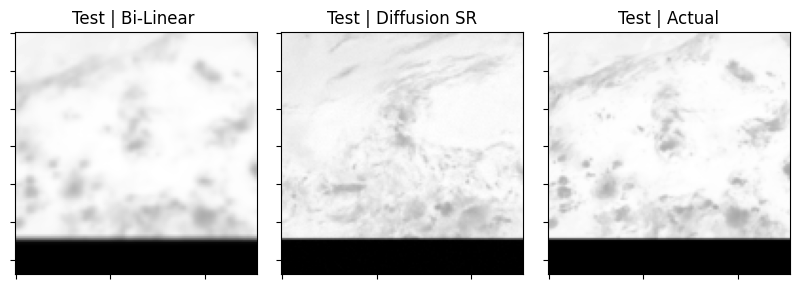

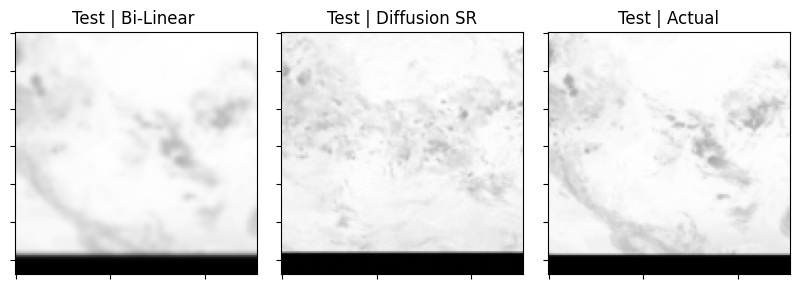

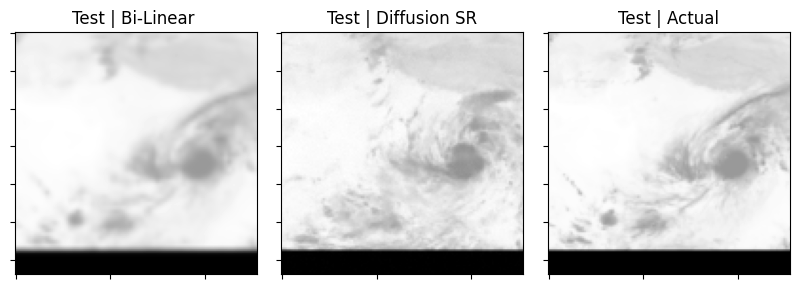

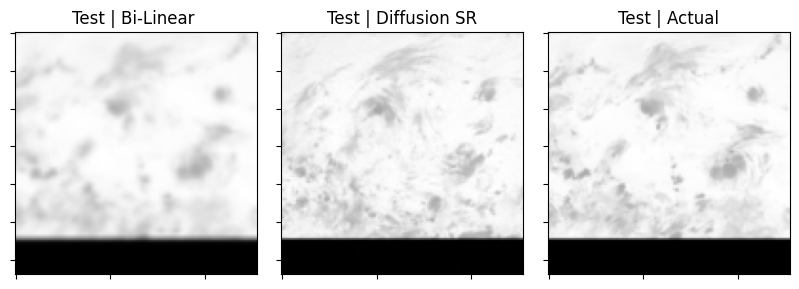

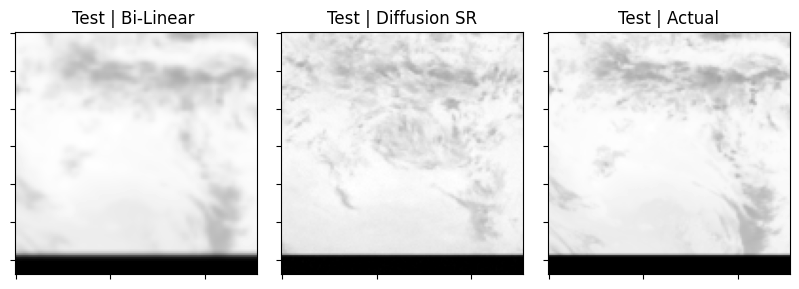

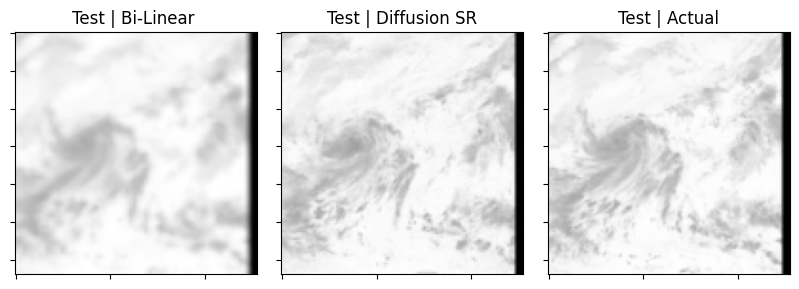

In [7]:
random_idx = [5]

dataloader = test_dataloader
img64, img128, era5 = dataloader.get_batch(dataloader.random_idx[random_idx[0]])
y_true, y_pred = get_images(dataloader, random_idx)

for idx in range(16):
    img_bi   = get_bilinear_interpolation(img64, idx)
    img_gen  = y_pred[idx][0]
    img_true = y_true[idx][0]    
    show_imgs(img_bi, img_gen, img_true, mode="Test")

Sampling: 100%|███████████████████████████████| 250/250 [00:36<00:00,  6.90it/s]
2it [00:36, 18.33s/it]


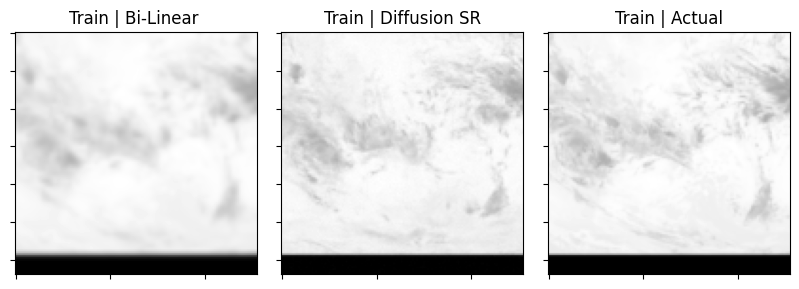

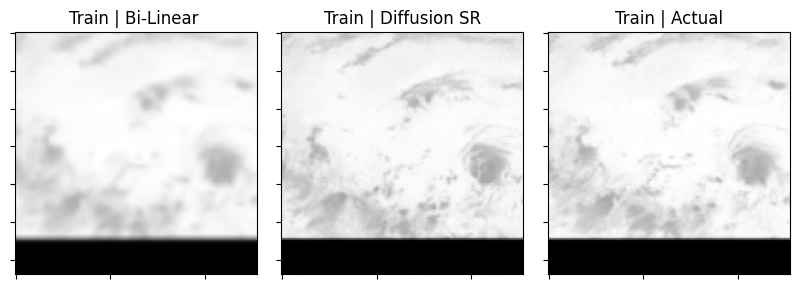

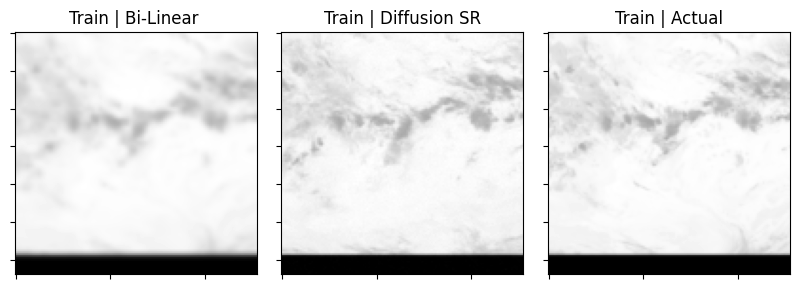

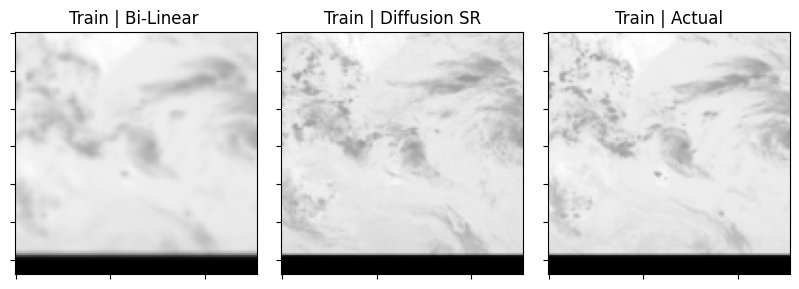

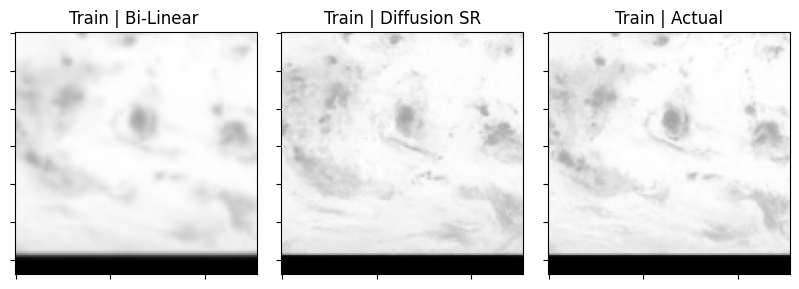

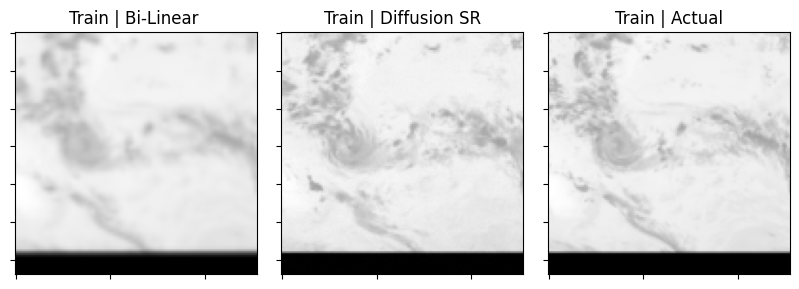

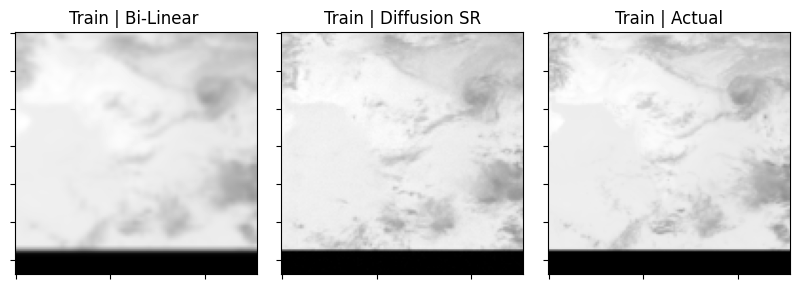

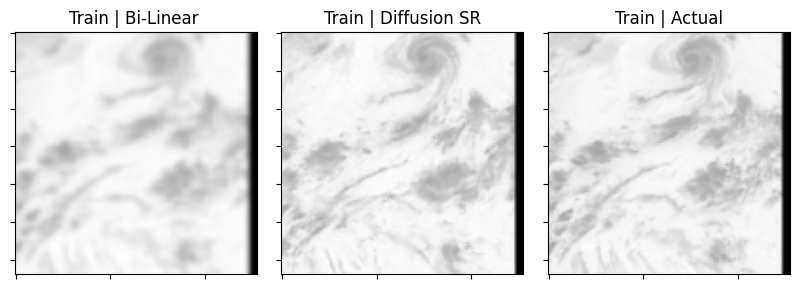

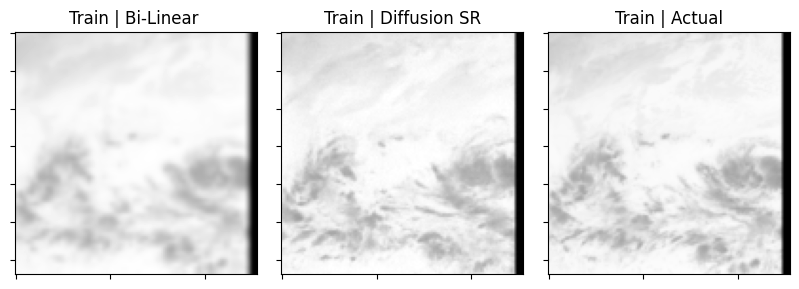

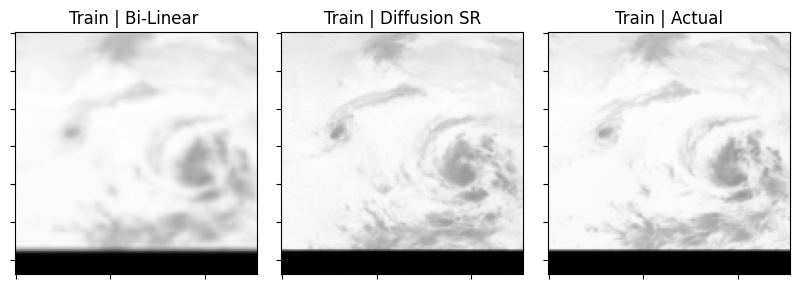

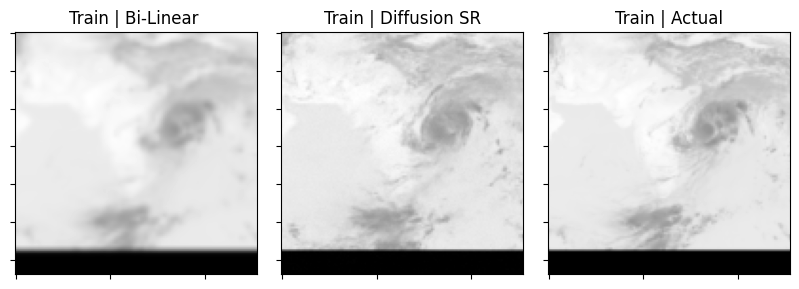

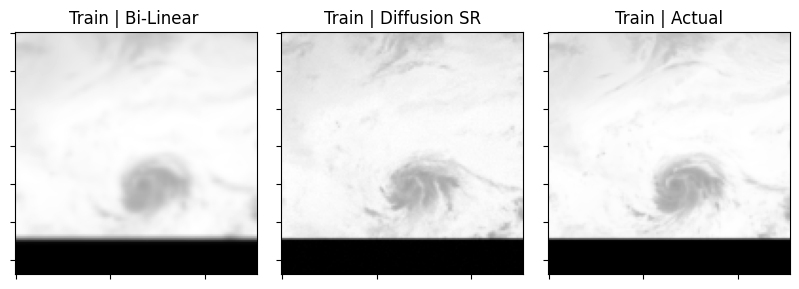

In [ ]:
random_idx = [5]

dataloader = train_dataloader
img64, img128, era5 = dataloader.get_batch(dataloader.random_idx[random_idx[0]])
y_true, y_pred = get_images(dataloader, random_idx)

for idx in range(16):
    img_bi   = get_bilinear_interpolation(img64, idx)
    img_gen  = y_pred[idx][0]
    img_true = y_true[idx][0]
    
    show_imgs(img_bi, img_gen, img_true, mode="Train")